In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-prediction-dataset/Traffic.csv


# KEY TAKEAWAYS FROM THE BELOW EDA: 📈

* **Number of Cars(CarCount)** has the **most contribution** to Traffic

* **Thursday** and **Wednesday** are the most **busy days** for traffic

* **Peak hours** of traffic are between **8:00am-10:00am** and **3:00pm-6:00pm**

* **Normal traffic** situation **counts** the **most**

* **Heavy Traffic** mostly occurs **after 9:00pm** 

* **Friday** sees the **minimum Traffic**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

# > Getting Data

In [3]:
data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/Traffic.csv')

# Lets get famililarize with the Data 🔬

In [4]:
data.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [6]:
data.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,16.000000,68.696573,14.917339,15.279570,15.324933,114.218414
std,8.945775,45.850693,12.847518,14.341986,10.603833,60.190627
min,1.000000,6.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,19.000000,5.000000,1.000000,6.000000,55.000000
50%,16.000000,64.000000,12.000000,12.000000,14.000000,109.000000
75%,24.000000,107.000000,22.000000,25.000000,23.000000,164.000000
max,31.000000,180.000000,70.000000,50.000000,40.000000,279.000000


In [7]:
data.isnull().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

# Exploratory Data Analysis 📈

<Axes: xlabel='Day of the week', ylabel='Count'>

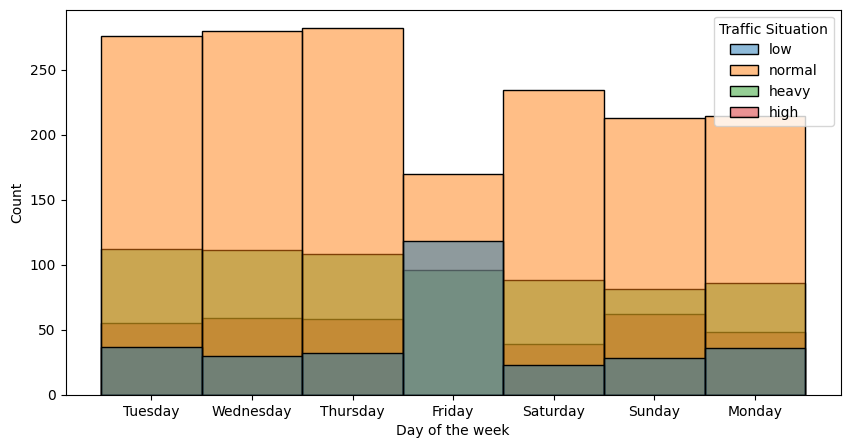

In [8]:
#['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       #'TruckCount', 'Total', 'Traffic Situation']
plt.figure(figsize=(10,5))
sns.histplot(data=data, x="Day of the week", hue="Traffic Situation")

<Axes: xlabel='Date', ylabel='Count'>

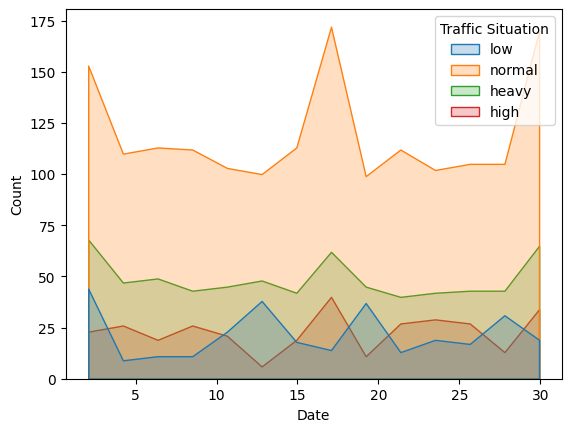

In [9]:
sns.histplot(data, x="Date", hue="Traffic Situation", element="poly")

<Axes: xlabel='Total', ylabel='Count'>

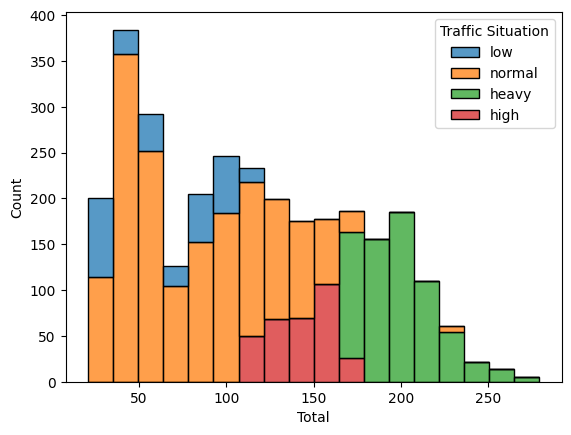

In [10]:
sns.histplot(data=data, x="Total", hue="Traffic Situation", multiple="stack")

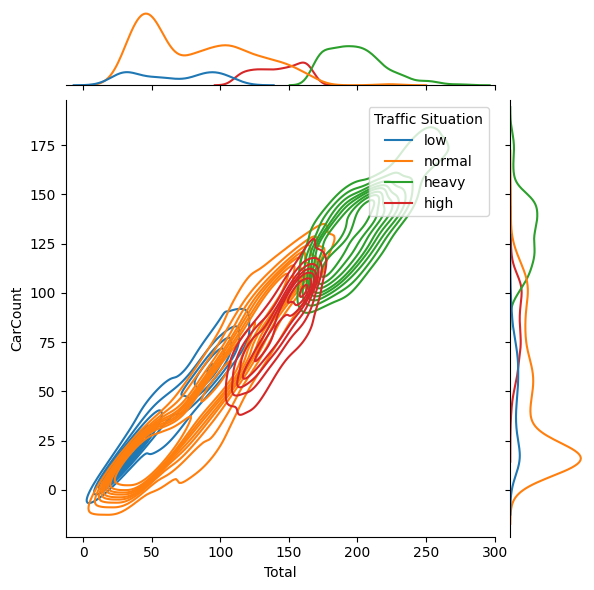

In [11]:
sns.jointplot(data=data, x="Total", y="CarCount", hue="Traffic Situation", kind="kde")

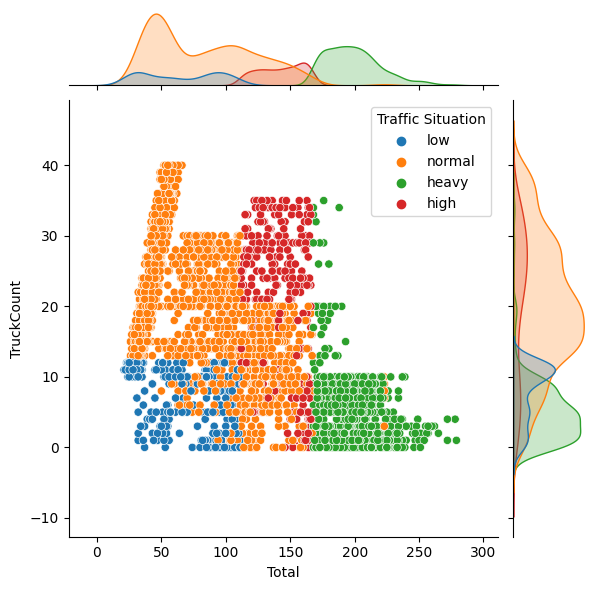

In [12]:
sns.jointplot(data=data, x="Total", y="TruckCount",
              hue="Traffic Situation")

# Feature Engineering 🛠⚙️

In [13]:
data.columns

Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')

In [14]:
# Distinct Classes in Target variable
data['Traffic Situation'].value_counts()

Traffic Situation
normal    1669
heavy      682
high       321
low        304
Name: count, dtype: int64

We have 04 distinct Classes

In [15]:
#Converting target variable 'Traffic Situation' into Numeric form
data['Traffic Situation'] = data['Traffic Situation'].replace({'low':0, 'normal':1, 
                                                              'heavy':2, 'high':3})

In [16]:
#Dealing with 'Day of the week' feature
data['Day of the week'].value_counts()

Day of the week
Tuesday      480
Wednesday    480
Thursday     480
Friday       384
Saturday     384
Sunday       384
Monday       384
Name: count, dtype: int64

In [17]:
#Converting Days of weak into Numeric form
data['Day of the week'] = data['Day of the week'].replace({'Monday':1,'Tuesday':2,
                                                          'Wednesday':3,'Thursday':4,
                                                          'Friday':5,'Saturday':6,
                                                          'Sunday':7})

In [18]:
test_temp = data.copy()

In [19]:
#Extracting Specific time-related information from 'Time(24:00 am/pm)' column

data['hour'] = pd.to_datetime(data['Time']).dt.hour #Hour in separate column
data['minute'] = pd.to_datetime(data['Time']).dt.minute #Minute in separate column


# replace 0 with AM
# replace 1 with PM

data['Temp'] = data['Time'].apply(lambda x: x.split(' ')[1]) #Temporary column for AM/PM
data['AM/PM'] = data['Temp'].replace({'AM':0,'PM':1})

/tmp/ipykernel_20/4231077955.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['hour'] = pd.to_datetime(data['Time']).dt.hour #Hour in separate column
/tmp/ipykernel_20/4231077955.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['minute'] = pd.to_datetime(data['Time']).dt.minute #Minute in separate column


In [20]:
#Now remove 'Temp' and 'Time' columns
data= data.drop(columns = ['Time','Temp'], axis=1)
data

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,hour,minute,AM/PM
0,10,2,31,0,4,4,39,0,0,0,0
1,10,2,49,0,3,3,55,0,0,15,0
2,10,2,46,0,3,6,55,0,0,30,0
3,10,2,51,0,2,5,58,0,0,45,0
4,10,2,57,6,15,16,94,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2971,9,4,16,3,1,36,56,1,22,45,1
2972,9,4,11,0,1,30,42,1,23,0,1
2973,9,4,15,4,1,25,45,1,23,15,1
2974,9,4,16,5,0,27,48,1,23,30,1


# Correlations using HeatMap 🗺

In [21]:
data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Traffic Situation']].corr()

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,hour,minute,AM/PM,Traffic Situation
Date,1.000000e+00,-1.672874e-02,-0.013453,-0.005089,-0.015536,0.024734,-0.010679,2.814316e-16,2.865092e-17,6.563367e-17,0.006594
Day of the week,-1.672874e-02,1.000000e+00,-0.002230,0.063583,-0.046031,-0.021895,-0.002953,-2.874150e-16,-5.201713e-17,-1.206884e-16,-0.024423
CarCount,-1.345292e-02,-2.230275e-03,1.000000,0.722539,0.692994,-0.628157,0.970443,1.480863e-01,-3.359952e-03,1.026836e-01,0.541331
BikeCount,-5.088914e-03,6.358283e-02,0.722539,1.000000,0.566364,-0.575399,0.797429,1.405488e-01,-7.978481e-03,1.404737e-01,0.407324
BusCount,-1.553604e-02,-4.603119e-02,0.692994,0.566364,1.000000,-0.546931,0.790705,1.657507e-01,-1.615958e-02,1.209151e-01,0.590153
TruckCount,2.473362e-02,-2.189502e-02,-0.628157,-0.575399,-0.546931,1.000000,-0.555471,-1.695231e-02,-1.119745e-03,9.508203e-05,-0.049809
Total,-1.067861e-02,-2.952752e-03,0.970443,0.797429,0.790705,-0.555471,1.000000,1.793136e-01,-8.310162e-03,1.370317e-01,0.631150
hour,2.814316e-16,-2.874150e-16,0.148086,0.140549,0.165751,-0.016952,0.179314,1.000000e+00,-1.003662e-17,8.667781e-01,0.175062
minute,2.865092e-17,-5.201713e-17,-0.003360,-0.007978,-0.016160,-0.001120,-0.008310,-1.003662e-17,1.000000e+00,-6.691275e-18,0.002993
AM/PM,6.563367e-17,-1.206884e-16,0.102684,0.140474,0.120915,0.000095,0.137032,8.667781e-01,-6.691275e-18,1.000000e+00,0.124653


<Axes: >

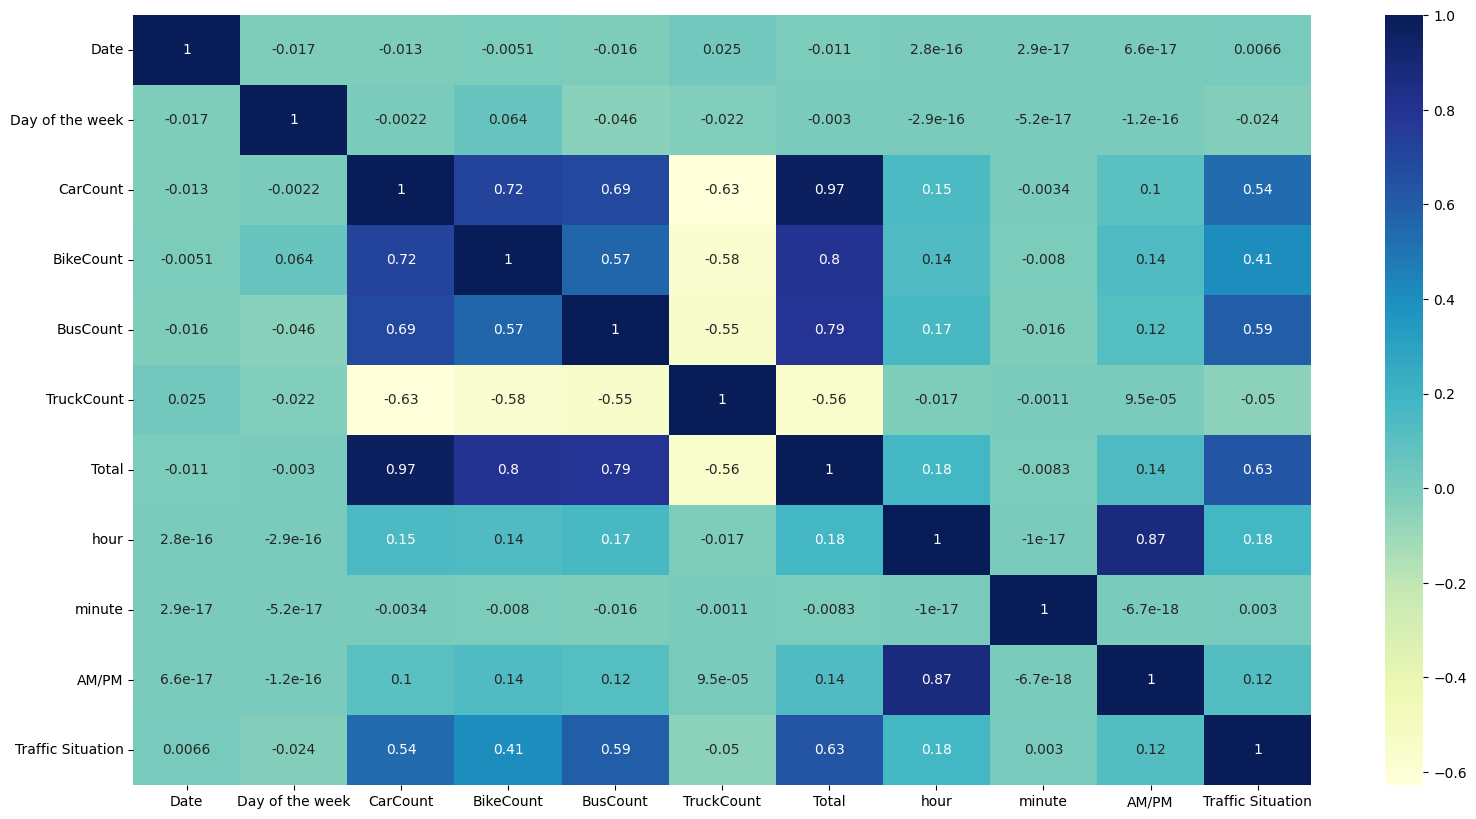

In [22]:
plt.figure(figsize = (19,10))
sns.heatmap(data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
           'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Traffic Situation']].corr(),
            cmap="YlGnBu",annot=True)

# Splitting Data

In [23]:
data.columns

Index(['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation', 'hour', 'minute', 'AM/PM'],
      dtype='object')

In [24]:
X= data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total','hour', 'minute', 'AM/PM']]

y= data['Traffic Situation'].values

In [25]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2 , random_state = 0)

# Feature Scaling

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

# Model Selection using Voting Classifier 💻

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [28]:
cl1 = LogisticRegression()
cl2 = RandomForestClassifier()
cl3 = SVC(probability=True)
cl4 = XGBClassifier()
cl5 = AdaBoostClassifier()

voting_cl = VotingClassifier(estimators = [('lr',cl1),('rf',cl2),('svc',cl3),
                                          ('xgb',cl4),('ada',cl5)], voting = 'hard')

voting_cl.fit(train_X, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('ada', AdaBoostClassifier())])

In [29]:
voting_pred = voting_cl.predict(test_X)

accuracy = accuracy_score(test_y, voting_pred)

In [30]:
accuracy

0.9446308724832215

In [31]:
#Voting classfier using Cross_validation
for clf, label in zip([cl1,cl2,cl3,cl4,cl5],['lr','rf','svc','xgb','ada']):
    scores = cross_val_score(clf, train_X, train_y, scoring='accuracy', cv=5)
    print('Accuracy: ', (scores.mean(), label))

Accuracy:  (0.8991596638655462, 'lr')
Accuracy:  (0.9949579831932773, 'rf')
Accuracy:  (0.9147058823529411, 'svc')
Accuracy:  (0.9983193277310924, 'xgb')
Accuracy:  (0.5609243697478992, 'ada')


* **RandomForest** accuracy: **99.4%**
* **XgBoost** accuracy: **99.8%**

In [32]:
#Solo RandomForest Accuracy
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)

rfc_pred = rfc.predict(test_X)
accuracy = accuracy_score(test_y, rfc_pred)
accuracy

0.9932885906040269

In [33]:
#Solo Xgboost Accuracy
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(train_X, train_y)

xgbc_pred = xgbc.predict(test_X)
accuracy = accuracy_score(test_y, xgbc_pred)
accuracy

1.0

* XGBoost Model isgiving 100% accuracy.
* It can be a sign of potential overfitting.
* Checking the model with cross_validation 

# Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_y, xgbc_pred)
conf_matrix

array([[ 64,   0,   0,   0],
       [  0, 334,   0,   0],
       [  0,   0, 138,   0],
       [  0,   0,   0,  60]])

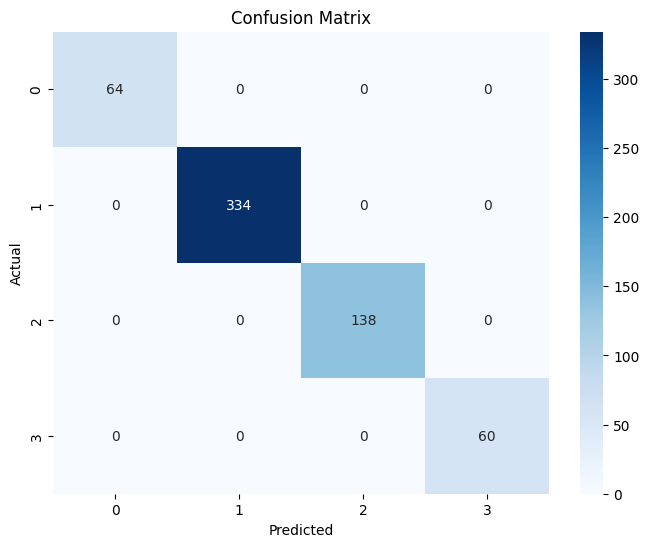

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(4), yticklabels=range(4)) 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Kindly **UPVOTE****👍** .
# **I am New to Machine Learning**. **Your Upvote** gives me **Immense Encouragement**